In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
import scipy.io
import os
# import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

2024-07-22 20:20:50.990646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 20:20:50.990819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 20:20:51.012111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 20:20:51.087078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 20:20:52.497047: W tensorflow/compiler/tf2

In [2]:
import sys
sys.version

'3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]'

## Data preparation

In [3]:
IN_X,IN_Y=768,1024
OUT_X,OUT_Y=96,128
SUBSAMPLING_FACTOR=IN_X//OUT_X

In [4]:
def gauss_distribution(x,u=0,sigma=10):
    return np.expand_dims(1/(np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(0.5)*(((x-u)/sigma)**2)),axis=0)

In [5]:
def get_density_map_gaussian(im,points,gaussian_radius=4):
    density_map=np.zeros((OUT_X,OUT_Y))
    w,h=OUT_Y,OUT_X
    num_gt=len(points)
    
    for point in points:
        point=np.round(point).astype(int)
        point[0],point[1]=min(h-1,point[1]),min(w-1,point[0])
        x=np.linspace(-gaussian_radius,gaussian_radius,(gaussian_radius*2)+1)
        gaussian_map=np.multiply(gauss_distribution(x),gauss_distribution(x).T)
        gaussian_map/=np.sum(gaussian_map)
        
        x_left,x_right,y_up,y_down=0,gaussian_map.shape[1],0,gaussian_map.shape[0]
        if point[1]<gaussian_radius:
            x_left=gaussian_radius-point[1]
        if point[0]<gaussian_radius:
            y_up=gaussian_radius-point[0]
        if point[1]+gaussian_radius>=w:
            x_right=gaussian_map.shape[1]-(gaussian_radius+point[1]-w)-1
        if point[0]+gaussian_radius>=h:
            y_down=gaussian_map.shape[0]-(gaussian_radius+point[0]-h)-1
        density_map[
            max(0,point[0]-gaussian_radius):min(density_map.shape[0],point[0]+gaussian_radius+1),
            max(0,point[1]-gaussian_radius):min(density_map.shape[1],point[1]+gaussian_radius+1),
        ]+=gaussian_map[y_up:y_down,x_left:x_right]
    density_map/=np.sum(density_map/len(points))
    return density_map

In [6]:
train_imgs = "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/ShanghaiTech/part_B/test_data/images/"
train_maps = "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/ShanghaiTech/part_B/test_data/ground-truth/"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6778872..2.5042818].


<function matplotlib.pyplot.show(close=None, block=None)>

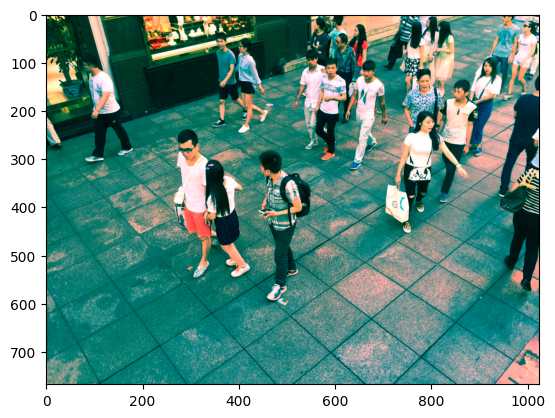

In [7]:
IN = "IMG_1"
im_array = img_to_array(load_img(train_imgs + IN + '.jpg', target_size=(IN_X, IN_Y)))
im_array/=255
im_array[:,:,0] = (im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1] = (im_array[:,:,1]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,2] = (im_array[:,:,2]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])

X= im_array
plt.imshow(X)
plt.show

In [8]:
# mat = scipy.io.loadmat(train_maps +'GT_' + IN + '.mat')
# points = mat['image_info'][0][0][0][0]

# points /= SUBSAMPLING_FACTOR
# y = get_density_map_gaussian(im_array, points, sigma = 5)

# plt.figure(figsize=(20,12))
# plt.imshow(y)

# plt.show()

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size,SUBSAMPLING_FACTOR=8):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list=os.listdir(images)
        self.SUBSAMPLING_FACTOR=SUBSAMPLING_FACTOR

    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))
  
    def __getitem__(self, idx):
        x,y = self.__data_generation(idx)
        return x,y
  
    def __data_generation(self, idx):
        x = []
        y = []

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):
            
            im_array=img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(IN_X,IN_Y)))
            im_array/=255.
            im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
            im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
            im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])
            x.append(im_array)
            mat=scipy.io.loadmat(self.maps+os.listdir(self.maps)[j])
            points=mat['image_info'][0][0][0][0][0]
            points/=self.SUBSAMPLING_FACTOR
            
            density_map_present=get_density_map_gaussian(im_array,points,gaussian_radius=5)
            y.append(density_map_present)
        return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

In [10]:
batch_size = 1
lr = 1e-4
epoch = 10


In [11]:
train_gen = DataGenerator(train_imgs, train_maps,batch_size, SUBSAMPLING_FACTOR)

## Modeling

In [12]:
def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        input_shape=(IN_X,IN_Y,3),
        include_top=False,)
    
    block4_conv3=[base_model.get_layer(layer_name).output for layer_name in ["block4_conv3"]]
    
    return Model(
        inputs=[base_model.inputs],outputs=[block4_conv3]
    )

get_base_model().summary()

2024-07-22 20:20:56.298167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 20:20:56.362572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 20:20:56.362697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 20:20:56.368323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 20:20:56.368413: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768, 1024, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 768, 1024, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 768, 1024, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 384, 512, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 384, 512, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 384, 512, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 192, 256, 128)     0     

In [13]:
inputs=tf.keras.Input(shape=(IN_X,IN_Y,3))
x=get_base_model()(inputs)
x = x[0] 
init=RandomNormal(0.01)

x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(256, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(128, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(64, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(1, (1,1), activation = 'relu', dilation_rate=1,kernel_initializer=init,padding='same')(x)

out=Reshape((96,128))(x)
model=tf.keras.Model(inputs=inputs,outputs=out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768, 1024, 3)]    0         
                                                                 
 model_1 (Functional)        [(None, 96, 128, 512)]    7635264   
                                                                 
 conv2d (Conv2D)             (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 128, 256)      1179904   
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 128, 128)      2950

/home/dhruv/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [17]:
def euclidean_loss(y_true, y_pred):
    return tf.sqrt(tf.math.reduce_sum(tf.square(y_true - y_pred)))

In [18]:
LR = 1e-5
model.compile(
    loss = euclidean_loss,
    optimizer = Adam(learning_rate = LR),
    metrics = 'accuracy'
)

In [19]:
history = model.fit(train_gen, verbose = 1, shuffle = True, epochs = epoch)

Epoch 1/10


2024-07-22 20:21:45.469537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-22 20:21:45.753723: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-22 20:21:48.149634: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-22 20:21:49.753890: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff7caa8aa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-22 20:21:49.753973: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-22 20:21:49.781951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721659909.947954   14846 devic

316/316 [==============================] - 290s 836ms/step - loss: 1332073728.0000 - accuracy: 0.0072
Epoch 2/10
316/316 [==============================] - 261s 823ms/step - loss: 4049560.2500 - accuracy: 0.0199
Epoch 3/10
316/316 [==============================] - 256s 807ms/step - loss: 1663610.8750 - accuracy: 0.0851
Epoch 4/10
316/316 [==============================] - 254s 801ms/step - loss: 719073.6250 - accuracy: 0.1304
Epoch 5/10
316/316 [==============================] - 253s 798ms/step - loss: 316858.5625 - accuracy: 0.1561
Epoch 6/10
316/316 [==============================] - 253s 798ms/step - loss: 162508.5000 - accuracy: 0.1748
Epoch 7/10
316/316 [==============================] - 254s 801ms/step - loss: 87707.6016 - accuracy: 0.1881
Epoch 8/10
316/316 [==============================] - 252s 794ms/step - loss: 50633.6406 - accuracy: 0.1995
Epoch 9/10
316/316 [==============================] - 253s 797ms/step - loss: 31244.6582 - accuracy: 0.2045
Epoch 10/10
316/316 [======

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6778872..2.5042818].


1/1 [==============================] - 2s 2s/step
The actual number of people is= 23
The predicted number of people is = 14928.377


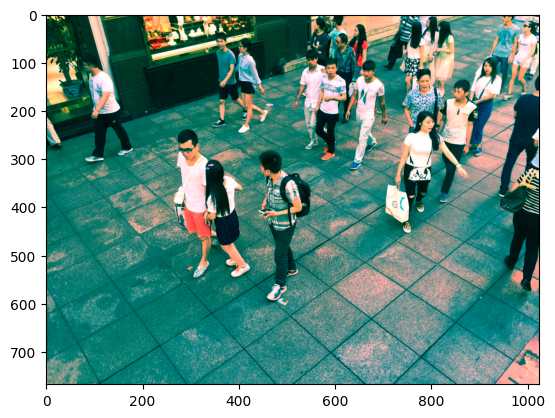

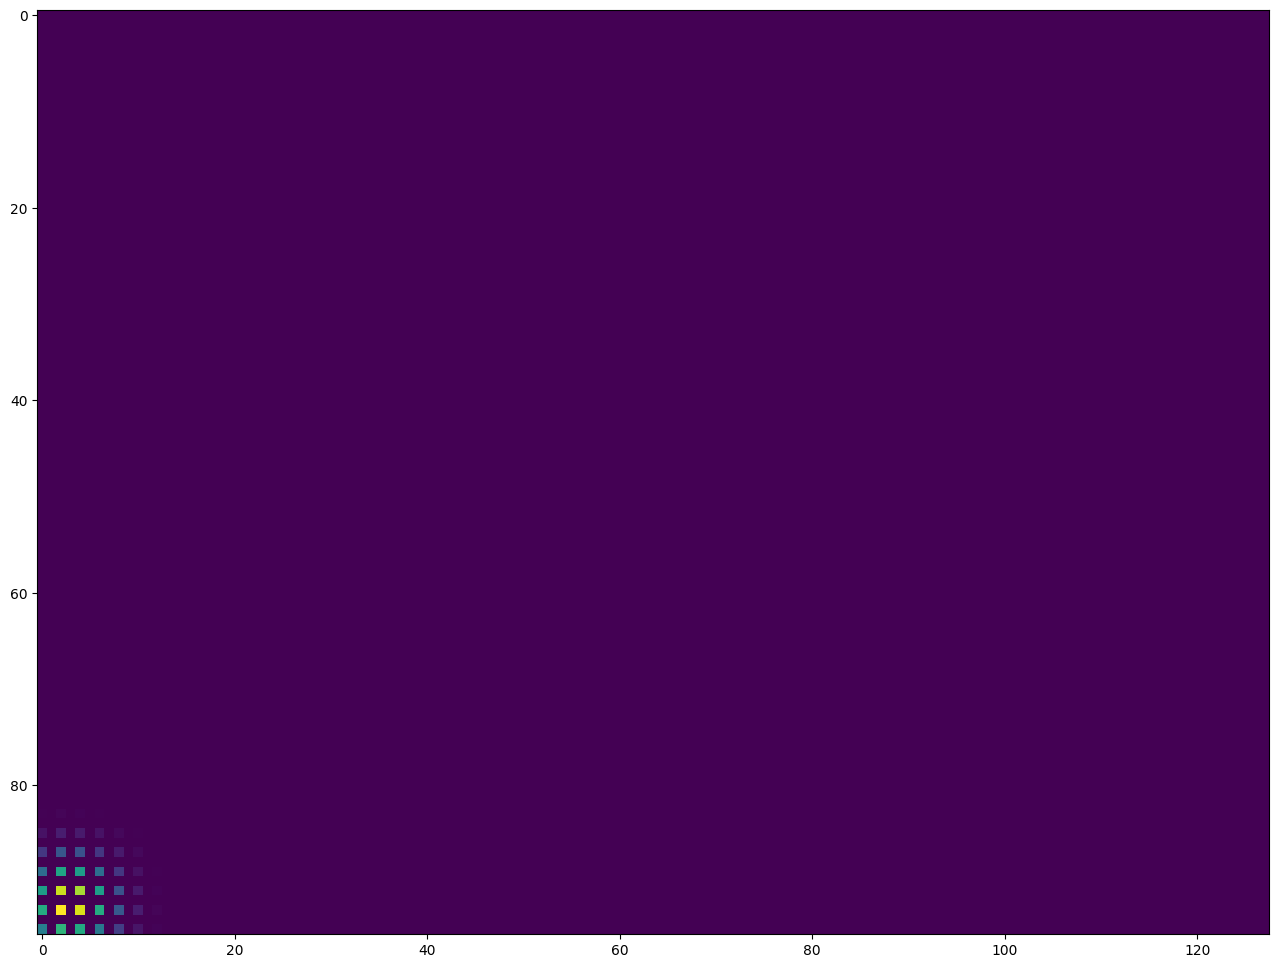

In [24]:
IN = "IMG_1"
im_array = img_to_array(load_img(train_imgs + IN + '.jpg', target_size=(IN_X, IN_Y)))
im_array/=255
im_array[:,:,0] = (im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1] = (im_array[:,:,1]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,2] = (im_array[:,:,2]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])

X= im_array
plt.imshow(X)
plt.show

output=model.predict(tf.expand_dims(im_array,axis=0))
output=np.reshape(output,(OUT_X,OUT_Y))

n_people=np.sum(output)
mat=scipy.io.loadmat(train_maps+'GT_'+IN+'.mat')
points=mat['image_info'][0][0][0][0][0]
points/=SUBSAMPLING_FACTOR

num_gt=np.squeeze(points).shape[0]
print("The actual number of people is=",num_gt)
print("The predicted number of people is =",n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)